In [1]:
# Jupyter Notebook Settings
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# General imports
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import json
# from workspace_utils import active_session
from PIL import Image

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader

# Torchvision imports
from torchvision.datasets import ImageFolder
from torchvision import models, transforms, datasets

# Custom function and class imports
from functions_helper import imshow
from functions_init import init_hp, init_data, init_net, init_tracker
from classifiers import SN_Classifier, DN_Classifier
from functions_training import train_net, fpass
from functions_testing import load_checkpoint, json_maps, prediction, process_image

# Autodetect device or set manually
device = ("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# device = "cuda"
print(device)



cpu


# Image Classifier

In this notebook, I will go through my process to create an image classifier that is trained to classify flower images via Transfer Learning using a pretrained model from Pytorch.<br/>

The majority of the functions used here are the same functions used by the Command Line Interface scripts train.py and predict.py.<br/>
For any additional functions, I will include them within the cells they are used.

### Structure of Notebook:<br/>
1) The Hyper Parameters<br/>
2) The Data<br/>
3) The Pretrained Net<br/>
    - Default Pretrained SqueezeNet Classifier
    - Default Pretrained DenseNet Classifier
    - Picking a Pretrained Net Architecture
4) The Custom Classifier<br/>
5) The Tracker<br/>
6) Training & Validation<br/>
7) Sanity Check 1: Images and Labels from DataLoaders<br/>
8) Sanity Check 2: Single Forward Pass through Network<br/>
9) Training Function<br/>
10) Testing<br/>
11) Prediction<br/>



# The Hyper Parameters

Hyper Parameters Dict:
- Batch Size for DataLoader
- Learning Rate for optimizer
- Number of Epochs for training
- Shuffle for Train, Valid, Test Datasets
- Hidden Units for Classifier Layers 1 and 2
- Dropout Probability for Classifier Units
- Initialize Parameters for Classifier Weights and Bias

In [18]:
# Batch Size = Number of Data Samples per Batch, used by DataLoader
batch_size = 50

# Learning Rate = Amount to scale the magnitude of the changes to the weights during training updates, used by optimizer
learn_rate = 0.0025

# Number of times to train over the entire dataset
n_epochs = 2

# Shuffle training, validation, testing dataset
shuffle = [True, True, True]

# Tuple of two ints, corresponding to the number of units in Layer 1 and Layer 2 of the Classifier respectively
hidden_units = (1024, 512)

# Probability of any given unit being dropped out. This is activated when model.training = True / when model.train is used. This is used to increase the ability of the model to generalize which will help avoid overfitting the data and decrease the minimum validation loss
p_dropout = 0.3

# Params to initialize Classifier Weights Mean, Std and Bias Values
init_params = [0, 0.01, 0.1]

# Init Hyper Params Dict
hp = init_hp(batch_size, learn_rate, n_epochs, shuffle, hidden_units, p_dropout, init_params)

# Show Hyper Params Dict structure
print("Hyper Params Dict:\n")
for key1, value1 in hp.items():
    print(f"{key1:15} {value1}")



Hyper Params Dict:

batch_size      50
learn_rate      0.0025
n_epochs        2
shuffle         [True, True, True]
hidden_units    (1024, 512)
p_dropout       0.3
init_params     [0, 0.01, 0.1]


# The Data

Data Dict:<br/>
- Train, Valid, Test
    - Data Directories
    - Transforms
    - DataSets
    - DataLoaders
    - Number of Images
    - Number of Batches
    - Number of Classes

In [19]:
# Get cwd
cwd = os.getcwd()

# Define Data Directory
data_dir = cwd + "/flower_data"

# Init Data Dict
data = init_data(data_dir, hp)

# Show Data Dict structure
print("Data Dict:\n")
for key1, value1 in data.items():
    
    for key2, value2 in data[key1].items():
        if (type(value2) == str) or (type(value2) == int):
            print(f"{key1:10}{key2:15}{value2}")
        else:
            print(f"{key1:10}{key2:15}{type(value2)}")
    print("\n")
    

Data Dict:

train     dirs           /Users/dziyaee/code/final_project/flower_data/train
train     transforms     <class 'torchvision.transforms.transforms.Compose'>
train     dataset        <class 'torchvision.datasets.folder.ImageFolder'>
train     dataloader     <class 'torch.utils.data.dataloader.DataLoader'>
train     n_images       6552
train     n_batches      132
train     n_classes      102


valid     dirs           /Users/dziyaee/code/final_project/flower_data/valid
valid     transforms     <class 'torchvision.transforms.transforms.Compose'>
valid     dataset        <class 'torchvision.datasets.folder.ImageFolder'>
valid     dataloader     <class 'torch.utils.data.dataloader.DataLoader'>
valid     n_images       818
valid     n_batches      17
valid     n_classes      102


test      dirs           /Users/dziyaee/code/final_project/flower_data/test
test      transforms     <class 'torchvision.transforms.transforms.Compose'>
test      dataset        <class 'torchvision.datase

# The Pretrained Net


The pretrained net is downloaded from the available torchvision models. In this Notebook, I will be using SqueezeNet (squeezenet1_0) as my default net, and DenseNet (densenet121) as my secondary net.<br/>


#### Default Pretrained SqueezeNet Classifier

This Net's Conv Layer produces an output of shape (B x 512 x 13 x 13). I have chosen to use a Global Average Pool as the first layer of my SqueezeNet Classifier in order to change the shape to (B x 512). This will then be passed through the three layers of the classifier. The number of classes needs to be explicitly changed from 1000 to 102


In [20]:
test_model = models.squeezenet1_0(pretrained=True)
print(f"Classifier:\n              {test_model.classifier}")
print(f"Number of input channels:  {test_model.classifier[1].in_channels}")
print(f"Number of output channels: {test_model.classifier[1].out_channels}")
print(f"Number of classes:         {test_model.num_classes}")


Classifier:
              Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)
Number of input channels:  512
Number of output channels: 1000
Number of classes:         1000


#### Default Pretrained DenseNet Classifier

This Net's conv layer produces an output of shape (B x 1024). The DenseNet Classifier does not require a Global Average Pool layer at the start as this seems to be done automatically within the transition between the conv layer and the classifier.

In [21]:
test_model = models.densenet121(pretrained=True)
print(f"Classifier:\n              {test_model.classifier}")
print(f"Number of input features:  {test_model.classifier.in_features}")
print(f"Number of output features: {test_model.classifier.out_features}")


Classifier:
              Linear(in_features=1024, out_features=1000, bias=True)
Number of input features:  1024
Number of output features: 1000


### Picking a Pretrained Net Architecture

Net Dict:<br/>
- Classifier
- In Features
- Hidden Units
- Out Features
- Criterion
- Optimizer
- Model
- Model Name

In [22]:
# Specify the architecture of the pretrained net
arch = "squeezenet"
# arch = "densenet"

# Init Net Dict
net = init_net(data, hp, arch)

# Set pretrained model's required_grad to false (freeze network params)
for param in net['model'].parameters():
    param.requires_grad = False


# The Custom Classifier
#### Linear:
Layer 1: Linear(in_features, H1)<br/>
Layer 2: Linear(H1, H2)<br/>
Layer 3: Linear(H2, out_features)<br/>

out_features = number of classes = 102<br/>
H1 = 1024 by default, H2 = 512 by default<br/>
in_features = 512 for SqueezeNet, 1024 for DenseNet<br/>

#### Dropouts:
Layer 1: On<br/>
Layer 2: On<br/>
Layer 3: Off<br/>

#### Activations:
Layer 1: ReLU<br/>
Layer 2: ReLU<br/>
Layer 3: LogSoftMax<br/>

#### SqueezeNet Classifier Special Note:
This Classifier also uses a Global Average Pool (AvgPool2d) as the first step after receiving the input from the Conv Layer. 

In [23]:
# After requires_grad is turned off for the pretrained model, update the model's classifier to the chosen custom classifier
if arch.lower() == "squeezenet":

    # Replace the default SqueezeNet classifier with our custom classifier
    net['model'].classifier = SN_Classifier(net, hp)

elif arch.lower() == "densenet":

    # Replace the default DenseNet classifier with our custom classifier
    net['model'].classifier = DN_Classifier(net, hp)

# After classifier is updated, define criterion and optimizer, and update net dict. Note that Optimizer is only assigned to the model.classifier
net['criterion'] = nn.NLLLoss()
net['optimizer'] = optim.Adam(net['model'].classifier.parameters(), lr=learn_rate)
net['classifier'] = net['model'].classifier

# Show Net Dict structure
print("Net Dict:\n")
for key1, value1 in net.items():
    if key1 == 'classifier':
        print(f"{key1:15}\n{value1}")
    elif (type(value1) == int) or (type(value1) == str) or (type(value1) == tuple):
        print(f"{key1:15}{value1}")
    else:
        print(f"{key1:15}{type(value1)}")


Net Dict:

classifier     
SN_Classifier(
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (avgpool2d): AvgPool2d(kernel_size=13, stride=13, padding=0)
)
in_features    512
hidden_units   (1024, 512)
out_features   102
criterion      <class 'torch.nn.modules.loss.NLLLoss'>
optimizer      <class 'torch.optim.adam.Adam'>
model          <class 'torchvision.models.squeezenet.SqueezeNet'>
model_name     squeezenet


# The Tracker

During training and validation, I have decided to validate every time the training cycle has gone through a number of batches equal to the total number of validation batches. For example, if there are 15 validation batches, validation should occur once every 15 training batches.
Then, the validation loss/acc will be calculcated as the average of the accumulated validation batch loss/acc. In order to make a fair comparison, the last 15 training batches are also averaged and stored. This happens every time there is a new validation cycle.

#### To calculate the number of validations, we do the following:<br/>
number of total training batches = number of epochs * number of training batches<br/>
number of validations = floor(number of total training batches / number of validation batches)

#### We also calculcate the number of total validation batches as follows:<br/>
number of total validation batches = number of validations * number of validation batches


Tracker Dict:<br/>
- Train
    - Batch Loss/Acc: Size = number of total training batches
    - Average Loss/Acc: Size = number of validations
    - Epoch Loss/Acc: Size = number of epochs
- Valid
    - Batch Loss/Acc: Size = number of total validation batches
    - Average Loss/Acc: Size = number of validations
- Test
    - Batch Loss/Acc: Size = number of testing batches
    - Average Loss/Acc: Size = 1

In [24]:
# init the tracker dict
track = init_tracker(data, hp)

# Show Tracker Dict structure
print("Tracker Dict:\n")
for key1, value1 in track.items():

    for key2, value2 in track[key1].items():
        
        try:
            
            print(f"{key1:10} {key2:15} {type(value2)} Size = {value2.size}")
            
        except:
            
            print(f"{key1:10} {key2:15} {type(value2)}")
    print("\n")

Tracker Dict:

train      batch_loss      <class 'numpy.ndarray'> Size = 264
train      batch_acc       <class 'numpy.ndarray'> Size = 264
train      epoch_loss      <class 'numpy.ndarray'> Size = 2
train      epoch_acc       <class 'numpy.ndarray'> Size = 2
train      av_loss         <class 'numpy.ndarray'> Size = 15
train      av_acc          <class 'numpy.ndarray'> Size = 15


valid      batch_loss      <class 'numpy.ndarray'> Size = 255
valid      batch_acc       <class 'numpy.ndarray'> Size = 255
valid      av_loss         <class 'numpy.ndarray'> Size = 15
valid      av_acc          <class 'numpy.ndarray'> Size = 15


test       batch_loss      <class 'numpy.ndarray'> Size = 17
test       batch_acc       <class 'numpy.ndarray'> Size = 17
test       av_loss         <class 'int'>
test       av_acc          <class 'int'>




# Training and Validation



In [25]:
# Define Saved Checkpoints Directory
save_dir = cwd + "/checkpoints/"

# Provide string to append to checkpoint filename if desired
checkpoint_append = "_1"

# Create full checkpoint path
checkpoint_path = save_dir + arch + checkpoint_append + ".pth"


In [26]:
# Print relevant info prior to training & validation

# These three variables will be calculated within the functions when needed, but I am showing them here explicitly as well
n_total_train_batches = data['train']['n_batches'] * hp['n_epochs']
n_valids = int(np.floor(n_total_train_batches / data['valid']['n_batches']))
n_total_valid_batches = data['valid']['n_batches'] * n_valids

print(f"\nHyper Params:")
print(f"Batch Size       = {hp['batch_size']}")
print(f"Learning Rate    = {hp['learn_rate']}")
print(f"Number of Epochs = {hp['n_epochs']}")
print(f"Shuffle          = {hp['shuffle']}")
print(f"Dropout          = {hp['p_dropout']}")
print(f"L1 Hidden Units  = {hp['hidden_units'][0]}")
print(f"L2 Hidden Units  = {hp['hidden_units'][1]}")
print(f"Init Params      = {hp['init_params']}")
print("-" * 100)
print(f"\nData:")
print(f"Data Directory                     = {data_dir}")
print(f"Save Directory                     = {save_dir}")
print(f"Checkpoint Path                    = {checkpoint_path}")
print(f"Number of Training Batches         = {data['train']['n_batches']}")
print(f"Number of Validation Batches       = {data['valid']['n_batches']}")
print(f"Number of Validations              = {n_valids}")
print(f"Number of Total Training Batches   = {n_total_train_batches}")
print(f"Number of Total Validation Batches = {n_total_valid_batches}")
print("-" * 100)
print(f"\nNet:")
print(f"In Features  = {net['in_features']}")
print(f"Out Features = {net['out_features']}")
print(f"Pretrained Net Name: {net['model_name']}")
print(f"Criterion:         \n{net['criterion']}")
print(f"Optimizer:         \n{net['optimizer']}")
print(f"Classifier:        \n{net['classifier']}")





Hyper Params:
Batch Size       = 50
Learning Rate    = 0.0025
Number of Epochs = 2
Shuffle          = [True, True, True]
Dropout          = 0.3
L1 Hidden Units  = 1024
L2 Hidden Units  = 512
Init Params      = [0, 0.01, 0.1]
----------------------------------------------------------------------------------------------------

Data:
Data Directory                     = /Users/dziyaee/code/final_project/flower_data
Save Directory                     = /Users/dziyaee/code/final_project/checkpoints/
Checkpoint Path                    = /Users/dziyaee/code/final_project/checkpoints/squeezenet_1.pth
Number of Training Batches         = 132
Number of Validation Batches       = 17
Number of Validations              = 15
Number of Total Training Batches   = 264
Number of Total Validation Batches = 255
----------------------------------------------------------------------------------------------------

Net:
In Features  = 512
Out Features = 102
Pretrained Net Name: squeezenet
Criterion:         

# Sanity Check 1: Images and Labels from DataLoaders

Here, I will be extracting images and labels from each dataloader. I will also get the class to name and class to folder maps using my json_maps function. Then, I will create two sets of images, the first containing the de-normalized images, and the second containing the normalized images. Both sets will also be reshaped such that the RGB color channels are on axis 2 instead of axis 0 in order to use plt.imshow()

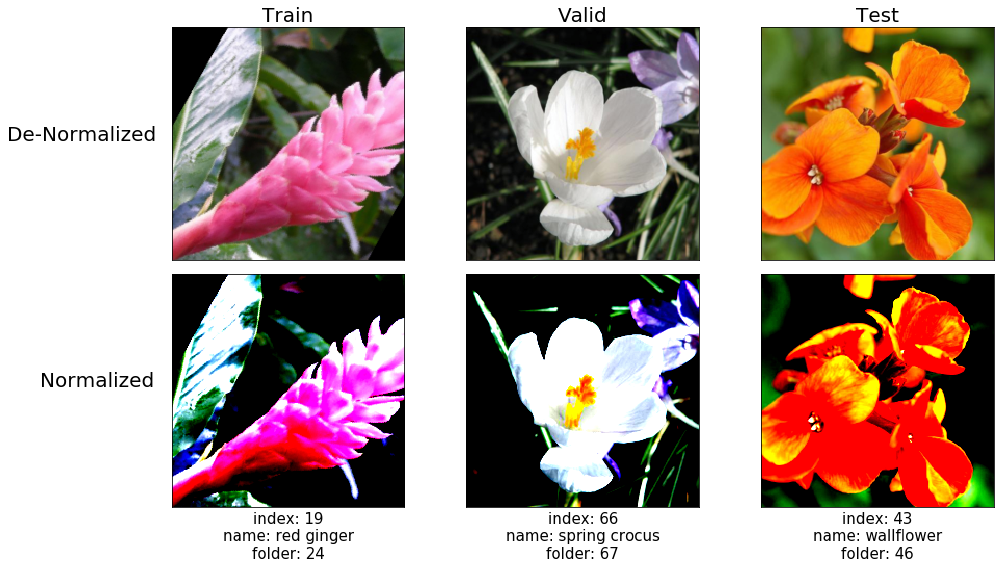

In [27]:
name_map, folder_map = json_maps("cat_to_name.json", data['train']['dataset'].class_to_idx)

# Image Batch Shapes = (B x 3 x 224 x 224), Label Batch Shapes = (B)
train_images, train_labels = next(iter(data['train']['dataloader']))
valid_images, valid_labels = next(iter(data['valid']['dataloader']))
test_images, test_labels = next(iter(data['test']['dataloader']))

# Mean/STD Reshaped to (3 x 1 x 1)
mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

# Image Shapes = (3 x 224 x 224), Label Shapes = (1)
denorm_images = [train_images[0], valid_images[0], test_images[0]]
norm_images = denorm_images.copy()
labels = [train_labels[0], valid_labels[0], test_labels[0]]

for i in range(3):
    
    # De-Normalize, then reshape to (224 x 224 x 3) for plt.imshow
    denorm_images[i] = (denorm_images[i] * std) + mean
    denorm_images[i] = denorm_images[i].numpy().transpose(1, 2, 0)
    denorm_images[i] = np.clip(denorm_images[i], 0, 1)
    
    # Reshape to (224 x 224 x 3) for plt.imshow
    norm_images[i] = norm_images[i].numpy().transpose(1, 2, 0)
    norm_images[i] = np.clip(norm_images[i], 0, 1)

fig, ax = plt.subplots(2, figsize=(15, 8), ncols=3)

# Column Titles
titles = ['Train', 'Valid', 'Test']

# Iterate through rows
for r in range(2):
    
    # First Row Labels and Image Set
    if r == 0:
        
        images = denorm_images
        ax[r, 0].set_ylabel("De-Normalized", rotation=0, fontsize=20, labelpad=90)
    
    # Second Row Labels and Image Set
    else:
        
        images = norm_images
        ax[r, 0].set_ylabel("Normalized", rotation=0, fontsize=20, labelpad=75)
    
    # Iterate through Columns
    for c in range(3):
        
        # Plot Images
        ax[r, c].imshow(images[c])
        
        # Set First Row Column Titles
        ax[0, c].set_title(titles[c], fontsize=20)
        
        # Remove Ticks
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])
        ax[r, c].set_xticklabels([])
        ax[r, c].set_yticklabels([])    
        
        # Set Second Row xlabels including class index, flower name, folder name
        i = labels[c].item()
        ax[1, c].set_xlabel(f"index: {i}\nname: {name_map[i]}\nfolder: {folder_map[i]}", fontsize=15)
        
fig.tight_layout()
        
        

# Sanity Check 2: Single Forward Pass through Network

Here, I want to make sure a forward pass through the network results in the expected input/output shapes. I also expect the accuracy to average around ((1 / C) * 100)%, where C = number of classes. For example, if C = 102, I would expect the accuracy to average around ((1 / 102) * 100)% = 0.98%. This is because an untrained classifier should have about equal probability for each class prediction across the dataset.

In [28]:
# Copy training batch
images = train_images.clone()
labels = train_labels.clone()

# Assign device
images = images.to(device)
labels = labels.to(device)
net['model'].to(device)

# Compute Loss
log_ps = net['model'].forward(images)
loss = net['criterion'](log_ps, labels)

# Compute Accuracy
ps = torch.exp(log_ps)
_, top_class = ps.topk(1, dim=1)
success = torch.eq(top_class, labels.view(top_class.shape))
acc = torch.mean(success.type(torch.FloatTensor))

# Prints
print("Forward Pass Test:\n")
print(f"Image Batch Shape       = {images.shape}")
print(f"Label Batch Shape       = {labels.shape}")
print(f"Log Probabilities Shape = {log_ps.shape}")
print(f"Probabilities Shape     = {ps.shape}")
print(f"Batch Loss              = {loss.item():.4f}")
print(f"Batch Acc               = {(acc.item() * 100):.1f}%")



Forward Pass Test:

Image Batch Shape       = torch.Size([50, 3, 224, 224])
Label Batch Shape       = torch.Size([50])
Log Probabilities Shape = torch.Size([50, 102])
Probabilities Shape     = torch.Size([50, 102])
Batch Loss              = 4.6036
Batch Acc               = 2.0%


### Training Function
The train_net function takes in all of the data generated thus far, including the data, hyper params, tracker, and net dicts. In addition, we pass the checkpoint path and the prints/plots toggles.<br/>






Epoch 1/2

Training...
Training Batch 1/264: Batch Loss = 4.6249... Batch Acc = 0.0%... Batch Time = 3.5s... Elapsed Time = 4.2s
Training Batch 2/264: Batch Loss = 4.6508... Batch Acc = 6.0%... Batch Time = 2.8s... Elapsed Time = 7.6s
Training Batch 3/264: Batch Loss = 4.5717... Batch Acc = 4.0%... Batch Time = 2.8s... Elapsed Time = 11.0s
Training Batch 4/264: Batch Loss = 4.5863... Batch Acc = 10.0%... Batch Time = 2.8s... Elapsed Time = 14.4s
Training Batch 5/264: Batch Loss = 4.6438... Batch Acc = 2.0%... Batch Time = 2.8s... Elapsed Time = 17.8s
Training Batch 6/264: Batch Loss = 4.3698... Batch Acc = 12.0%... Batch Time = 2.8s... Elapsed Time = 21.2s
Training Batch 7/264: Batch Loss = 4.4637... Batch Acc = 6.0%... Batch Time = 2.9s... Elapsed Time = 24.7s
Training Batch 8/264: Batch Loss = 4.4449... Batch Acc = 10.0%... Batch Time = 2.9s... Elapsed Time = 28.2s
Training Batch 9/264: Batch Loss = 4.5978... Batch Acc = 6.0%... Batch Time = 2.9s... Elapsed Time = 31.7s
Training Bat

Training Batch 36/264: Batch Loss = 3.1911... Batch Acc = 26.0%... Batch Time = 3.1s... Elapsed Time = 248.4s
Training Batch 37/264: Batch Loss = 3.5740... Batch Acc = 18.0%... Batch Time = 3.1s... Elapsed Time = 252.1s
Training Batch 38/264: Batch Loss = 3.5318... Batch Acc = 16.0%... Batch Time = 3.1s... Elapsed Time = 255.8s
Training Batch 39/264: Batch Loss = 2.7818... Batch Acc = 32.0%... Batch Time = 3.1s... Elapsed Time = 259.6s
Training Batch 40/264: Batch Loss = 2.5135... Batch Acc = 32.0%... Batch Time = 3.1s... Elapsed Time = 263.2s
Training Batch 41/264: Batch Loss = 3.0735... Batch Acc = 24.0%... Batch Time = 3.1s... Elapsed Time = 266.9s
Training Batch 42/264: Batch Loss = 3.3169... Batch Acc = 26.0%... Batch Time = 3.1s... Elapsed Time = 270.7s
Training Batch 43/264: Batch Loss = 3.0153... Batch Acc = 36.0%... Batch Time = 3.1s... Elapsed Time = 274.3s
Training Batch 44/264: Batch Loss = 3.2922... Batch Acc = 26.0%... Batch Time = 3.1s... Elapsed Time = 278.0s
Training B

Training Batch 71/264: Batch Loss = 2.5052... Batch Acc = 32.0%... Batch Time = 3.0s... Elapsed Time = 490.9s
Training Batch 72/264: Batch Loss = 2.6891... Batch Acc = 40.0%... Batch Time = 3.0s... Elapsed Time = 494.5s
Training Batch 73/264: Batch Loss = 2.6826... Batch Acc = 28.0%... Batch Time = 3.0s... Elapsed Time = 498.1s
Training Batch 74/264: Batch Loss = 2.4951... Batch Acc = 38.0%... Batch Time = 3.0s... Elapsed Time = 501.7s
Training Batch 75/264: Batch Loss = 3.1130... Batch Acc = 24.0%... Batch Time = 3.0s... Elapsed Time = 505.3s
Training Batch 76/264: Batch Loss = 2.5503... Batch Acc = 36.0%... Batch Time = 3.0s... Elapsed Time = 509.0s
Training Batch 77/264: Batch Loss = 2.9122... Batch Acc = 18.0%... Batch Time = 3.0s... Elapsed Time = 512.6s
Training Batch 78/264: Batch Loss = 2.7316... Batch Acc = 26.0%... Batch Time = 3.0s... Elapsed Time = 516.2s
Training Batch 79/264: Batch Loss = 2.5293... Batch Acc = 38.0%... Batch Time = 3.0s... Elapsed Time = 519.7s
Training B

Training Batch 106/264: Batch Loss = 2.1991... Batch Acc = 42.0%... Batch Time = 3.0s... Elapsed Time = 727.7s
Training Batch 107/264: Batch Loss = 2.5460... Batch Acc = 36.0%... Batch Time = 3.0s... Elapsed Time = 731.3s
Training Batch 108/264: Batch Loss = 2.1883... Batch Acc = 42.0%... Batch Time = 3.0s... Elapsed Time = 734.9s
Training Batch 109/264: Batch Loss = 2.2432... Batch Acc = 42.0%... Batch Time = 3.0s... Elapsed Time = 738.4s
Training Batch 110/264: Batch Loss = 1.7536... Batch Acc = 52.0%... Batch Time = 2.9s... Elapsed Time = 742.0s
Training Batch 111/264: Batch Loss = 2.2818... Batch Acc = 40.0%... Batch Time = 2.9s... Elapsed Time = 745.5s
Training Batch 112/264: Batch Loss = 2.2454... Batch Acc = 40.0%... Batch Time = 3.0s... Elapsed Time = 749.0s
Training Batch 113/264: Batch Loss = 2.3941... Batch Acc = 40.0%... Batch Time = 3.0s... Elapsed Time = 752.6s
Training Batch 114/264: Batch Loss = 1.5656... Batch Acc = 56.0%... Batch Time = 3.0s... Elapsed Time = 756.2s
T

Training Batch 139/264: Batch Loss = 2.3097... Batch Acc = 44.0%... Batch Time = 2.9s... Elapsed Time = 953.1s
Training Batch 140/264: Batch Loss = 2.2711... Batch Acc = 32.0%... Batch Time = 2.9s... Elapsed Time = 956.6s
Training Batch 141/264: Batch Loss = 2.6026... Batch Acc = 36.0%... Batch Time = 3.0s... Elapsed Time = 960.1s
Training Batch 142/264: Batch Loss = 2.9308... Batch Acc = 28.0%... Batch Time = 3.1s... Elapsed Time = 963.7s
Training Batch 143/264: Batch Loss = 1.8526... Batch Acc = 56.0%... Batch Time = 3.0s... Elapsed Time = 967.2s
Training Batch 144/264: Batch Loss = 2.0127... Batch Acc = 46.0%... Batch Time = 2.9s... Elapsed Time = 970.7s
Training Batch 145/264: Batch Loss = 1.9436... Batch Acc = 46.0%... Batch Time = 2.9s... Elapsed Time = 974.1s
Training Batch 146/264: Batch Loss = 2.1277... Batch Acc = 38.0%... Batch Time = 2.9s... Elapsed Time = 977.6s
Training Batch 147/264: Batch Loss = 1.9489... Batch Acc = 52.0%... Batch Time = 2.9s... Elapsed Time = 981.1s
T

Training Batch 173/264: Batch Loss = 1.8864... Batch Acc = 46.0%... Batch Time = 3.0s... Elapsed Time = 1183.4s
Training Batch 174/264: Batch Loss = 1.7771... Batch Acc = 48.0%... Batch Time = 2.9s... Elapsed Time = 1186.8s
Training Batch 175/264: Batch Loss = 1.6218... Batch Acc = 56.0%... Batch Time = 2.9s... Elapsed Time = 1190.3s
Training Batch 176/264: Batch Loss = 1.7102... Batch Acc = 52.0%... Batch Time = 2.9s... Elapsed Time = 1193.8s
Training Batch 177/264: Batch Loss = 1.9818... Batch Acc = 46.0%... Batch Time = 3.0s... Elapsed Time = 1197.3s
Training Batch 178/264: Batch Loss = 1.7928... Batch Acc = 48.0%... Batch Time = 2.9s... Elapsed Time = 1200.7s
Training Batch 179/264: Batch Loss = 1.7537... Batch Acc = 54.0%... Batch Time = 3.0s... Elapsed Time = 1204.2s
Training Batch 180/264: Batch Loss = 1.7981... Batch Acc = 52.0%... Batch Time = 3.0s... Elapsed Time = 1207.7s
Training Batch 181/264: Batch Loss = 2.6055... Batch Acc = 30.0%... Batch Time = 3.0s... Elapsed Time = 

Training Batch 207/264: Batch Loss = 1.8966... Batch Acc = 42.0%... Batch Time = 3.0s... Elapsed Time = 1413.1s
Training Batch 208/264: Batch Loss = 1.5625... Batch Acc = 52.0%... Batch Time = 3.0s... Elapsed Time = 1416.6s
Training Batch 209/264: Batch Loss = 1.5717... Batch Acc = 62.0%... Batch Time = 3.0s... Elapsed Time = 1420.1s
Training Batch 210/264: Batch Loss = 1.5054... Batch Acc = 46.0%... Batch Time = 3.0s... Elapsed Time = 1423.6s
Training Batch 211/264: Batch Loss = 1.5286... Batch Acc = 62.0%... Batch Time = 3.0s... Elapsed Time = 1427.1s
Training Batch 212/264: Batch Loss = 1.6482... Batch Acc = 66.0%... Batch Time = 2.9s... Elapsed Time = 1430.6s
Training Batch 213/264: Batch Loss = 2.0912... Batch Acc = 42.0%... Batch Time = 2.9s... Elapsed Time = 1434.1s
Training Batch 214/264: Batch Loss = 2.2189... Batch Acc = 46.0%... Batch Time = 2.9s... Elapsed Time = 1437.5s
Training Batch 215/264: Batch Loss = 1.8729... Batch Acc = 50.0%... Batch Time = 3.0s... Elapsed Time = 

Training Batch 241/264: Batch Loss = 1.7597... Batch Acc = 58.0%... Batch Time = 2.9s... Elapsed Time = 1642.1s
Training Batch 242/264: Batch Loss = 2.0804... Batch Acc = 50.0%... Batch Time = 2.9s... Elapsed Time = 1645.5s
Training Batch 243/264: Batch Loss = 1.8552... Batch Acc = 46.0%... Batch Time = 3.1s... Elapsed Time = 1649.1s
Training Batch 244/264: Batch Loss = 1.9797... Batch Acc = 48.0%... Batch Time = 3.0s... Elapsed Time = 1652.5s
Training Batch 245/264: Batch Loss = 1.9478... Batch Acc = 52.0%... Batch Time = 3.0s... Elapsed Time = 1656.0s
Training Batch 246/264: Batch Loss = 1.4783... Batch Acc = 50.0%... Batch Time = 2.9s... Elapsed Time = 1659.5s
Training Batch 247/264: Batch Loss = 2.0374... Batch Acc = 52.0%... Batch Time = 2.9s... Elapsed Time = 1662.9s
Training Batch 248/264: Batch Loss = 1.5066... Batch Acc = 58.0%... Batch Time = 2.9s... Elapsed Time = 1666.4s
Training Batch 249/264: Batch Loss = 1.5462... Batch Acc = 60.0%... Batch Time = 2.9s... Elapsed Time = 

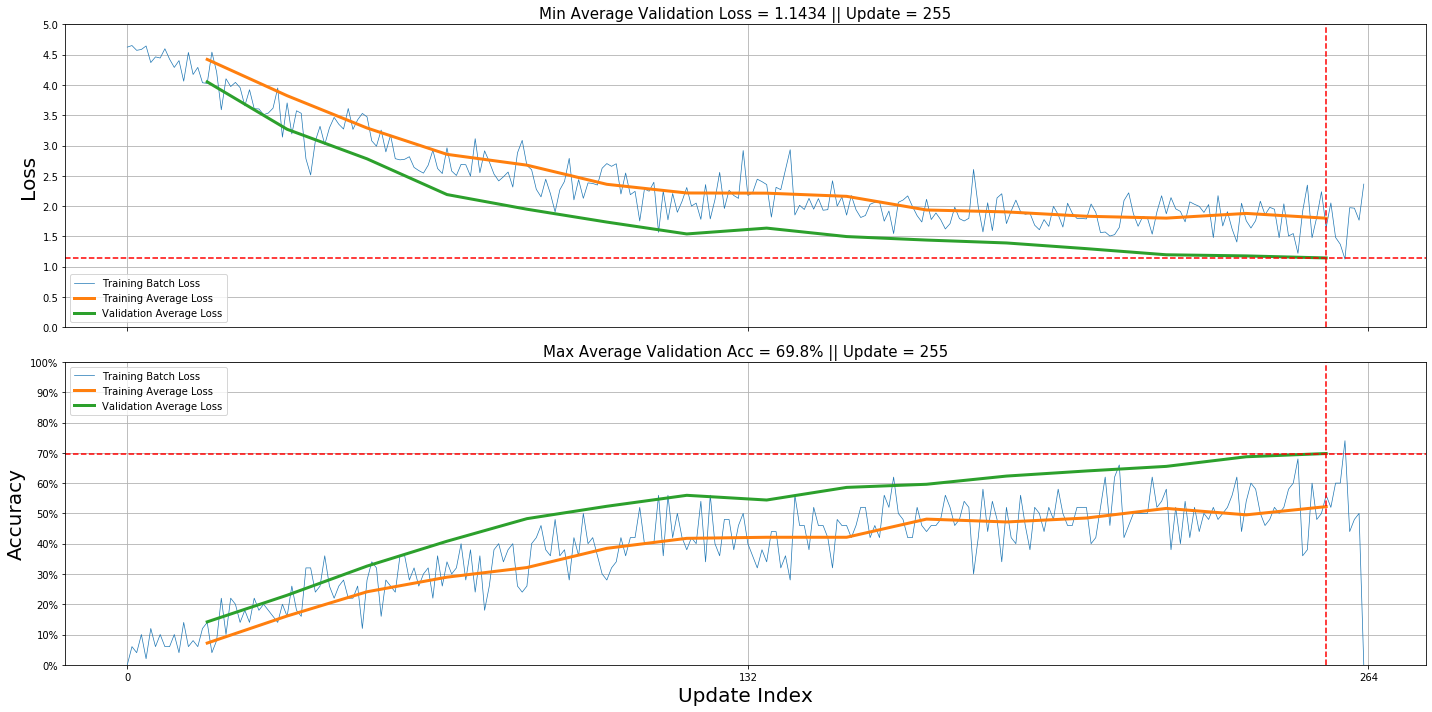

In [29]:
# Print/Plot settings

# Print every batch loss/acc for training and validation
batch_prints = True

# Print every validation average loss/acc for training and validation
valid_prints = True

# Print every epoch average loss/acc for training
epoch_prints = True

# Plot loss/acc graphs at the end of training
plots = True

# Run training & validation function
train_run = train_net(data, hp, track, net, device, checkpoint_path, batch_prints, valid_prints, epoch_prints, plots)



# Testing

For Testing, I will load a checkpoint and go through the test dataloader one time, calculating the loss and accuracy the same way it is done within my training function.
The test run is not made into a function since it is not used by the Command Line Interface scripts.



In [30]:
# Load checkpoint using the checkpoint generated during training (checkpoint_path) or give a custom path
checkpoint = load_checkpoint(checkpoint_path)

map_location = cpu


In [31]:
# prints settings

# Print every batch loss/acc for testing
batch_prints = True

# Print final testing dataset loss/acc
test_prints = True

start_time = time.time()

# Network: model, criterion, and optimizer. Assign model to current device
model = checkpoint['net']['model']
criterion = checkpoint['net']['criterion']
optimizer = checkpoint['net']['optimizer']
model.to(device)

# init tracker
test_track = init_tracker(data, hp)

# Data: Testing DataLoader, Number of Batches
test_loader = data['test']['dataloader']
n_test_batches = data['test']['n_batches']

# i = Testing Batch Index
i = 0

# Set Testing running loss/acc to zero
test_running_loss = 0
test_running_acc = 0

# Proceed with no gradient calculations for the entire testing set
with torch.no_grad():

    # Iterate through testing DataLoader
    for images, labels in test_loader:

        batch_time = time.time()

        # Set model to evaluation mode
        model.eval()

        # Assign image and label batch tensors to chosen device
        images = images.to(device)
        labels = labels.to(device)

        # Compute batch loss and acc using custom fpass function. Loss is computed via Negative Log-Likelihood Loss Criterion
        loss, acc = fpass(images, labels, model, criterion)

        # Update testing running loss / acc
        test_running_loss += loss.item()
        test_running_acc += acc.item()

        # Store test batch loss / acc
        track['test']['batch_loss'][i] = loss.item()
        track['test']['batch_acc'][i] = acc.item()

        if batch_prints:

            print(f"Test Batch {i + 1}/{n_test_batches}: Batch Loss = {loss.item():.4f}... Batch Acc = {(acc.item() * 100):.1f}%... Batch Time = {(time.time() - batch_time):.1f}s... Elapsed Time = {(time.time() - start_time):.1f}s")

        # End Testing Batch, iterate testing batch index j
        i += 1

    # Calculate average testing batch loss / acc
    track['test']['av_loss'] = test_running_loss / n_test_batches
    track['test']['av_acc'] = test_running_acc / n_test_batches

    if test_prints:

        print(f"\nTest Results: Average Loss = {(test_running_loss / n_test_batches):.4f}... Average Acc = {((test_running_acc / n_test_batches) * 100):.1f}%... Elapsed Time = {(time.time() - start_time):.1f}s")



Test Batch 1/17: Batch Loss = 1.0046... Batch Acc = 66.0%... Batch Time = 2.9s... Elapsed Time = 3.4s
Test Batch 2/17: Batch Loss = 1.2607... Batch Acc = 62.0%... Batch Time = 2.8s... Elapsed Time = 6.7s
Test Batch 3/17: Batch Loss = 0.8546... Batch Acc = 76.0%... Batch Time = 2.8s... Elapsed Time = 9.9s
Test Batch 4/17: Batch Loss = 1.4139... Batch Acc = 60.0%... Batch Time = 2.8s... Elapsed Time = 13.2s
Test Batch 5/17: Batch Loss = 0.9852... Batch Acc = 66.0%... Batch Time = 2.9s... Elapsed Time = 16.6s
Test Batch 6/17: Batch Loss = 1.1476... Batch Acc = 78.0%... Batch Time = 2.8s... Elapsed Time = 20.0s
Test Batch 7/17: Batch Loss = 1.3164... Batch Acc = 64.0%... Batch Time = 2.8s... Elapsed Time = 23.3s
Test Batch 8/17: Batch Loss = 1.1170... Batch Acc = 68.0%... Batch Time = 2.8s... Elapsed Time = 26.6s
Test Batch 9/17: Batch Loss = 1.1857... Batch Acc = 66.0%... Batch Time = 2.8s... Elapsed Time = 29.9s
Test Batch 10/17: Batch Loss = 1.4055... Batch Acc = 64.0%... Batch Time = 2

# Prediction

For prediction, I will first set up a function and script to get a random image from the test dataset. If preferred, one can also directly set the image path to pass to the prediction function.



819
819
PIL Image Size: (657, 500)
Tensor Image Shape: torch.Size([3, 224, 224])


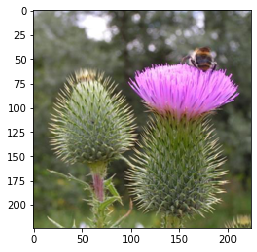

In [40]:
# Get test directory
test_dir = data['test']['dirs']

# Function to get all image paths in given directory
def get_paths(data_dir):
    
    # Loop through test directory and create a list of folder paths
    folders = [data_dir + "/" + i for i in os.listdir(data_dir) if not i.startswith(".")]
    
    # Loop through folders and create a list of image paths
    image_paths = [f + "/" + i for f in folders for i in os.listdir(f)]
    
    return image_paths

# Get image paths
test_paths = get_paths(test_dir)

# Double check to make sure number of test image paths = number of test images
n_test_images = data['test']['n_images']
print(n_test_images)
print(len(test_paths))

# Get random index within this range
random_index = np.random.choice(n_test_images, 1)[0]

# Get random image path within test directory using random index
random_path = test_paths[random_index]

# Load PIL Image to check size prior to processing
image_PIL = Image.open(random_path)
print(f"PIL Image Size: {image_PIL.size}")

# Process Image to epected type and shape (Tensor, 3 x 224 x 224)
image_TN = process_image(random_path)
print(f"Tensor Image Shape: {image_TN.shape}")

# imshow Test (this uses the imshow function that was already provided in the Notebook)
ax = imshow(image_TN);



/Users/dziyaee/code/final_project/flower_data/test/14/image_06052.jpg


Top Probabilities: [9.9946600e-01 3.8195244e-04 9.9082114e-05 2.8426568e-05 2.2735876e-05]
Top Classes:       [ 8 77  6 31 24]
Flower Names:      ['spear thistle', 'passion flower', "colt's foot", 'alpine sea holly', 'artichoke']
Folder Names:      ['14', '77', '12', '35', '29']


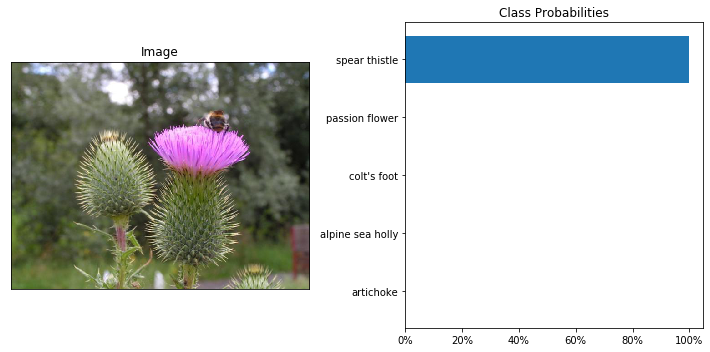

In [41]:
# Get random image path or provide your own
image_path = random_path
print(image_path)
print("\n")

# Provide top classes (recommended to stay betweein 1 and 10 for clarity of plot labels)
k = 5

# Get index to name and index to folder map
name_map, folder_map = json_maps("cat_to_name.json", data['test']['dataset'].class_to_idx)

# Prints and Plots toggles
prints=True
display_results=True

prediction(image_path, checkpoint, device, k, name_map, folder_map, prints, display_results);